<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>
[Back to top](#table_of_contents)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [5]:
taxi_jan_2024= pd.read_parquet('data/yellow_tripdata_2024-01.parquet')
taxi_data= pd.concat([taxi_jan_2024])

In [6]:
print(taxi_data.shape)
taxi_data.head()

(2964624, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [8]:
taxi_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [9]:
#keep meaniful columns for the task
taxi_data=taxi_data[['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count',
                    'trip_distance','RatecodeID','PULocationID','DOLocationID',
                    'payment_type','total_amount']]

In [10]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,16.10


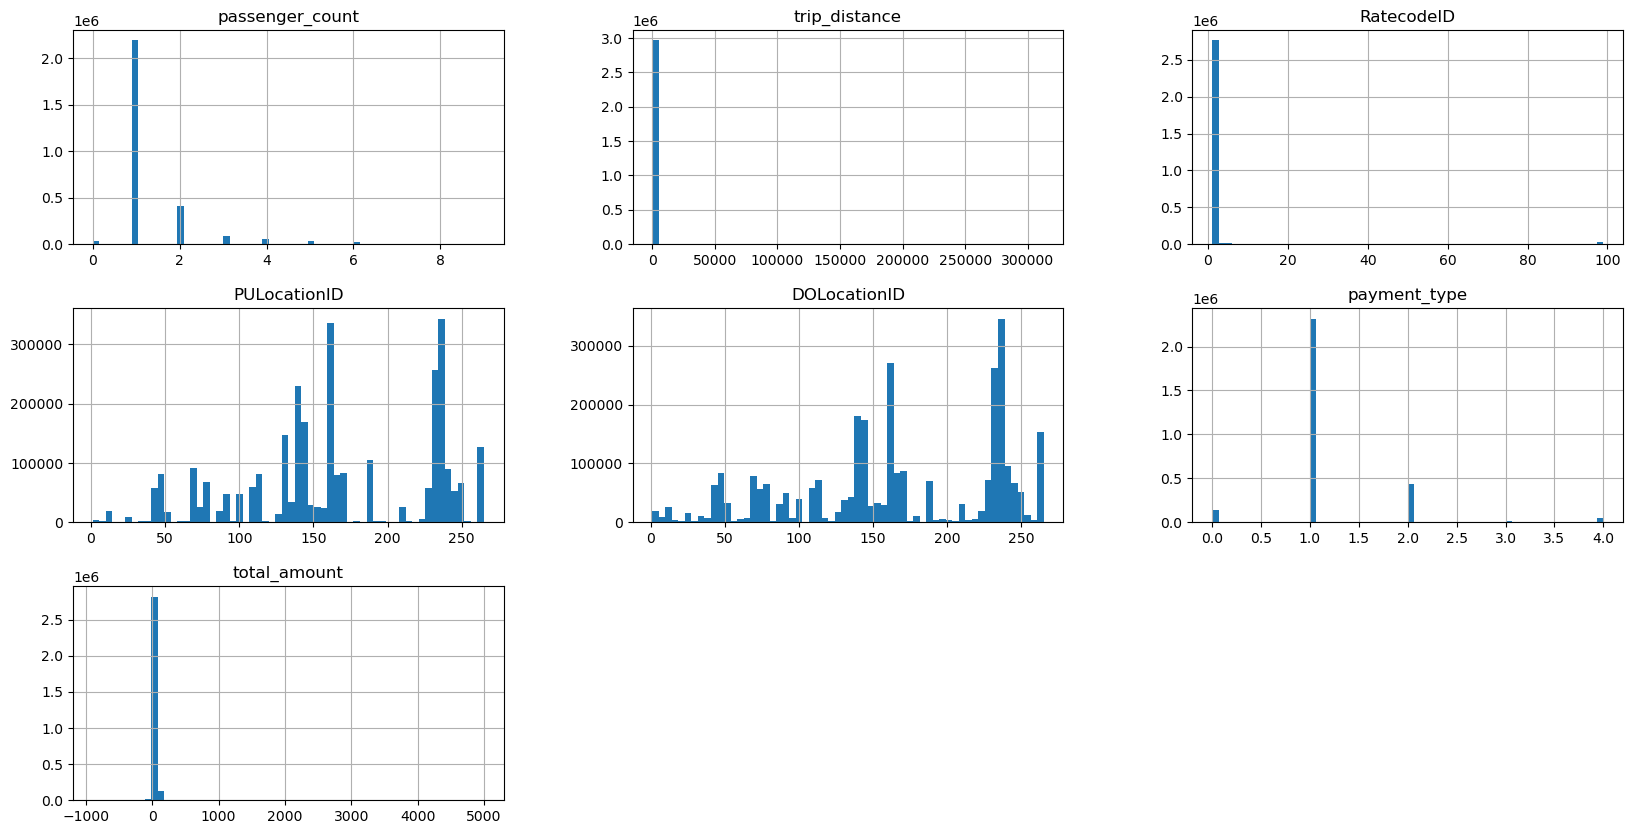

In [11]:
#visualize data in histograms
numeric_columns = taxi_data.select_dtypes(include=['number'])
numeric_columns.hist(figsize=(20,10),bins=60)
plt.show()

In [12]:
#notice outliers in ratecodeID, total_amount and trip_distance
taxi_data['RatecodeID'].value_counts()

RatecodeID
1.0     2663350
2.0       98713
99.0      28663
5.0       19410
3.0        7954
4.0        6365
6.0           7
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

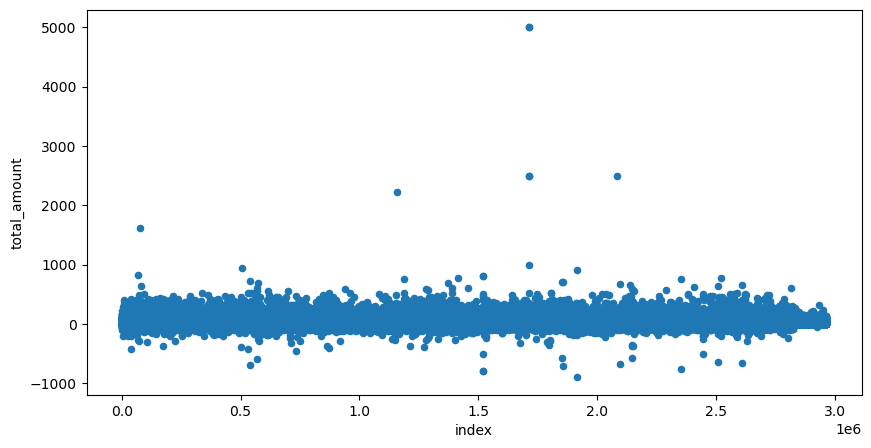

In [13]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

<Axes: xlabel='index', ylabel='total_amount'>

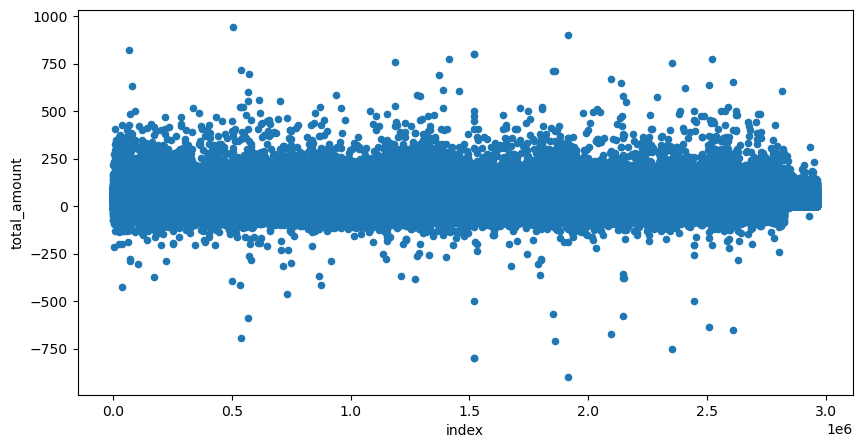

In [14]:
#values are manely under 1000$
taxi_data[taxi_data['total_amount']<1000].reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

(35504, 9)


<Axes: xlabel='index', ylabel='total_amount'>

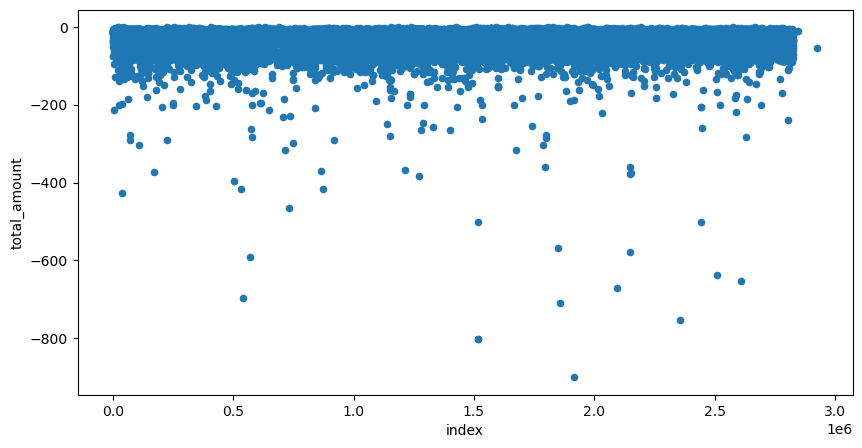

In [15]:
#notice negative values, how many are there?
print(taxi_data[taxi_data['total_amount']<0].shape)
taxi_data[taxi_data['total_amount']<0].reset_index().plot(kind='scatter', y='total_amount',x='index',figsize=(10,5))

In [16]:
#lets find some explanations
taxi_data[taxi_data['total_amount']<0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,-18.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,-34.25
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,249,113,4,-10.80
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,1.0,107,61,2,-38.10
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,1.0,90,225,4,-52.80


In [17]:
#there is some pattern in payment_type
taxi_data[taxi_data['total_amount']<0]['payment_type'].value_counts()

payment_type
4    21406
2     8326
3     5741
1       29
0        2
Name: count, dtype: int64

<Axes: >

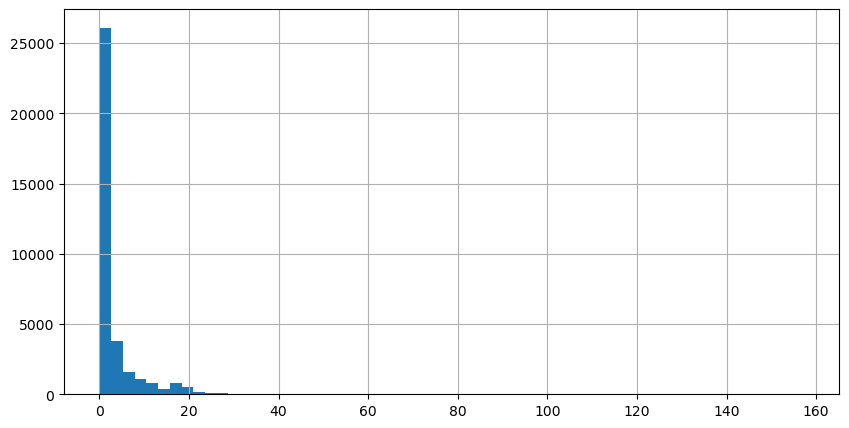

In [18]:
#what does the trip_distance looks like?
taxi_data[taxi_data['total_amount']<0]['trip_distance'].hist(bins=60, figsize=(10,5))

60% of negative amounts are dispute, so it's safe to remove them because it just gonna confuse the model.

In [20]:
#how about null values?
print(taxi_data[taxi_data['total_amount']==0].shape)
taxi_data[taxi_data['total_amount']==0].head()

(416, 9)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
854,2024-01-01 00:27:42,2024-01-01 00:28:49,1.0,0.2,1.0,239,143,4,0.0
29224,2024-01-01 10:01:27,2024-01-01 10:01:27,1.0,0.0,5.0,239,264,2,0.0
39191,2024-01-01 13:46:41,2024-01-01 14:12:06,1.0,0.0,99.0,42,216,1,0.0
39591,2024-01-01 13:03:22,2024-01-01 13:03:24,1.0,0.0,1.0,264,264,2,0.0
39592,2024-01-01 13:05:28,2024-01-01 13:05:35,1.0,0.0,1.0,193,193,2,0.0


In [21]:
taxi_data[taxi_data['total_amount']==0]['payment_type'].value_counts()

payment_type
1    129
4    128
3     83
2     65
0     11
Name: count, dtype: int64

<Axes: >

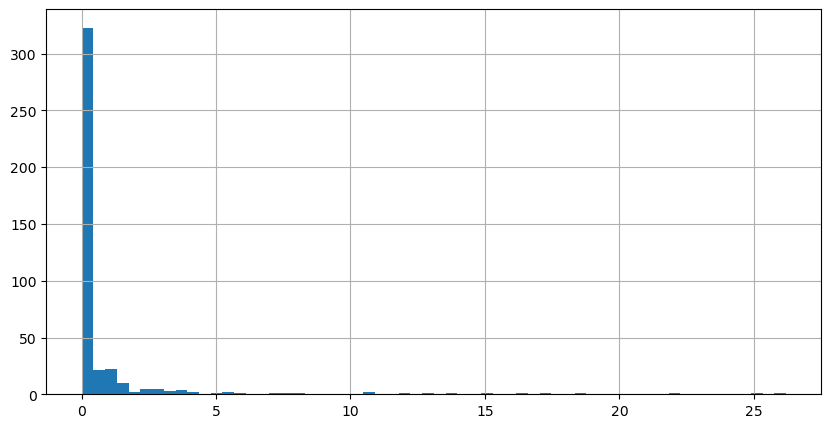

In [22]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [23]:
taxi_data[taxi_data['total_amount']==0]['trip_distance'].value_counts()

trip_distance
0.00     287
0.10      21
0.20       8
0.90       8
0.50       7
1.60       6
1.00       5
0.80       5
0.70       5
1.10       4
0.30       4
1.30       4
0.60       4
0.40       3
3.00       3
2.50       3
2.40       2
3.40       2
3.80       2
1.80       2
1.70       2
10.70      2
12.10      1
25.10      1
1.40       1
12.80      1
1.74       1
2.70       1
18.40      1
15.00      1
5.30       1
3.30       1
2.90       1
17.10      1
4.20       1
3.50       1
4.00       1
21.90      1
16.50      1
26.20      1
13.60      1
7.70       1
3.60       1
5.50       1
5.80       1
4.90       1
8.10       1
1.20       1
7.00       1
Name: count, dtype: int64

70% of trips with total_amount=0 have 0 trip distance, so it's safe to remove them.

<Axes: xlabel='index', ylabel='total_amount'>

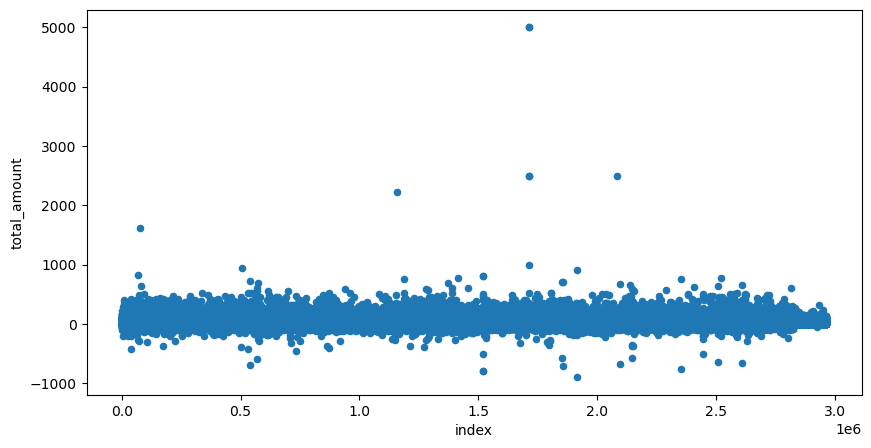

In [25]:
taxi_data.reset_index().plot(kind='scatter', y='total_amount', x='index', figsize=(10,5))

In [26]:
#let's see now how many positive outliers
taxi_data[taxi_data['total_amount']>200].shape

(2005, 9)

In [27]:
taxi_data['total_amount'].mean()

26.801504770925415

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [29]:
#keep total_amount between 0 and 200$
taxi_data_filtered=taxi_data[(taxi_data['total_amount']>=0)&(taxi_data['total_amount']<200)]

In [30]:
print(taxi_data.shape)
taxi_data_filtered.shape

(2964624, 9)


(2927107, 9)

In [31]:
taxi_data_filtered.isna().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140153
trip_distance                 0
RatecodeID               140153
PULocationID                  0
DOLocationID                  0
payment_type                  0
total_amount                  0
dtype: int64

In [32]:
taxi_data_filtered[taxi_data_filtered['RatecodeID'].isna()].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
2824462,2024-01-01 00:34:19,2024-01-01 00:51:22,NaN,2.04,NaN,143,141,0,16.72
2824463,2024-01-01 00:14:31,2024-01-01 00:19:29,NaN,1.60,NaN,236,238,0,17.16
2824464,2024-01-01 00:35:11,2024-01-01 01:13:40,NaN,0.00,NaN,142,79,0,25.01
2824465,2024-01-01 00:33:37,2024-01-01 00:50:34,NaN,0.00,NaN,237,4,0,21.79
2824466,2024-01-01 00:49:04,2024-01-01 01:01:16,NaN,0.00,NaN,244,50,0,38.65


# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [34]:
taxi_data_prepared=taxi_data_filtered.copy()

In [35]:
#let's work on data type
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
total_amount                    float64
dtype: object

In [36]:
taxi_data_prepared.loc[:,'RatecodeID']=taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID']=taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID']=taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type']=taxi_data_prepared['payment_type'].astype(str)

/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/172552378.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1.0' '1.0' '1.0' ... 'nan' 'nan' 'nan']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  taxi_data_prepared.loc[:,'RatecodeID']=taxi_data_prepared['RatecodeID'].astype(str)
/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/172552378.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['186' '140' '236' ... '211' '107' '138']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  taxi_data_prepared.loc[:,'PULocationID']=taxi_data_prepared['PULocationID'].astype(str)
/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/172552378.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise i

In [37]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [38]:
# Extract hour, day, month
taxi_data_prepared['transaction_date']=pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)
taxi_data_prepared['transaction_year']=taxi_data_prepared['tpep_pickup_datetime'].dt.year
taxi_data_prepared['transaction_month']=taxi_data_prepared['tpep_pickup_datetime'].dt.month
taxi_data_prepared['transaction_day']=taxi_data_prepared['tpep_pickup_datetime'].dt.day
taxi_data_prepared['transaction_hour']=taxi_data_prepared['tpep_pickup_datetime'].dt.hour
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,22.70,2024-01-01,2024,1,1,0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,18.75,2024-01-01,2024,1,1,0
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,31.30,2024-01-01,2024,1,1,0
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,17.00,2024-01-01,2024,1,1,0
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,16.10,2024-01-01,2024,1,1,0


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'total_amount'}>,
        <Axes: title={'center': 'transaction_date'}>],
       [<Axes: title={'center': 'transaction_year'}>,
        <Axes: title={'center': 'transaction_month'}>,
        <Axes: title={'center': 'transaction_day'}>],
       [<Axes: title={'center': 'transaction_hour'}>, <Axes: >, <Axes: >]],
      dtype=object)

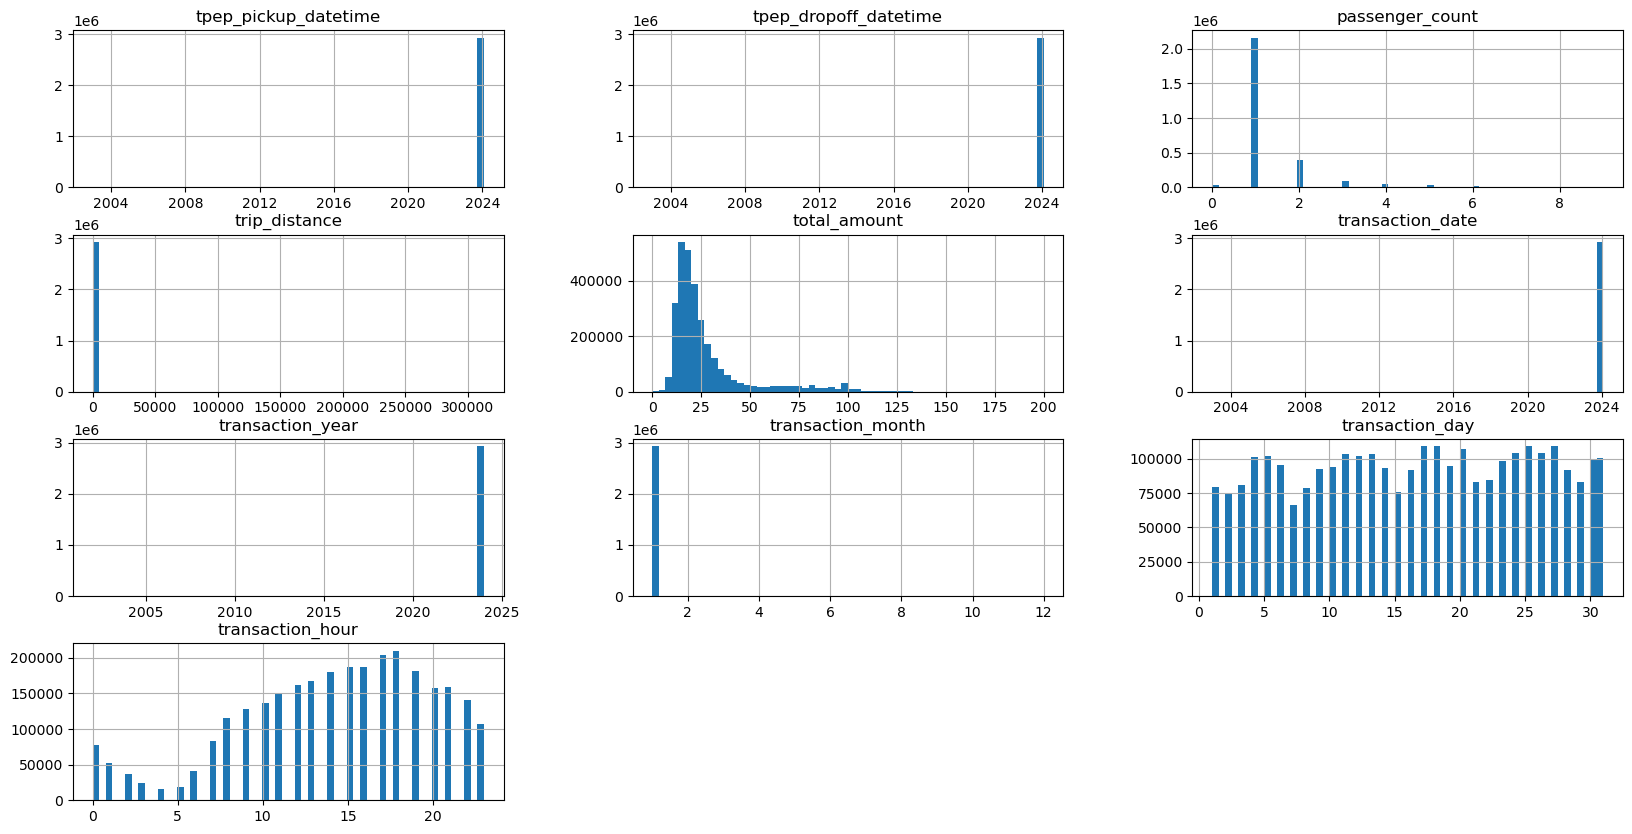

In [39]:
taxi_data_prepared.hist(figsize=(20,10),bins=60)

In [40]:
#filtring the date that supposed to be january 2024
taxi_data_prepared=taxi_data_prepared[taxi_data_prepared['transaction_year']==2024]
taxi_data_prepared=taxi_data_prepared[taxi_data_prepared['transaction_month']==1]

In [41]:
#leaving the features that i don't need for my problem
categorical_columns=['PULocationID','transaction_date','transaction_month','transaction_day','transaction_hour']
numerical_columns=['trip_distance','total_amount']
all_needed_columns=categorical_columns+numerical_columns

In [42]:
main_taxi_df=taxi_data_prepared[all_needed_columns]
print(main_taxi_df.shape)
main_taxi_df.head()

(2927090, 7)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,186,2024-01-01,1,1,0,1.72,22.70
1,140,2024-01-01,1,1,0,1.80,18.75
2,236,2024-01-01,1,1,0,4.70,31.30
3,79,2024-01-01,1,1,0,1.40,17.00
4,211,2024-01-01,1,1,0,0.80,16.10


In [43]:
#Aggregate data
taxi_grouped_by_region=main_taxi_df.groupby(categorical_columns).mean().reset_index()
taxi_grouped_by_region['count_of_transactions']=taxi_grouped_by_region.groupby(categorical_columns).count().reset_index()['total_amount']
print(taxi_grouped_by_region.shape)
taxi_grouped_by_region.head()

(77432, 8)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2024-01-01,1,1,5,0.000000,109.200000,1
1,1,2024-01-01,1,1,6,0.020000,76.000000,1
2,1,2024-01-01,1,1,13,0.000000,108.983333,1
3,1,2024-01-01,1,1,14,0.001667,85.680000,1
4,1,2024-01-01,1,1,15,0.000000,145.620000,1


<Axes: >

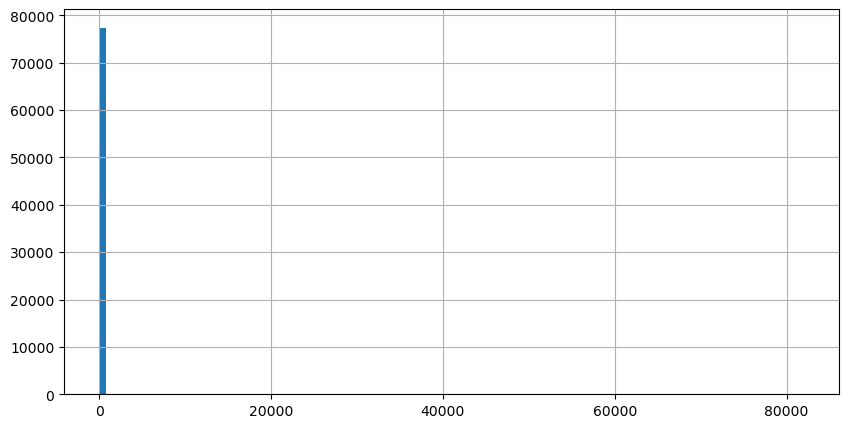

In [44]:
taxi_grouped_by_region['trip_distance'].hist(figsize=(10,5), bins=100)

<Axes: >

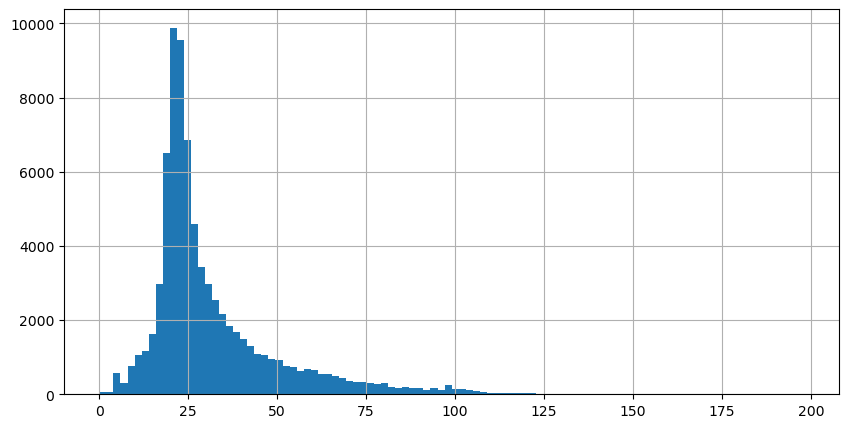

In [45]:
taxi_grouped_by_region['total_amount'].hist(figsize=(10,5), bins=100)

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [47]:
#baseline model without feature engineering
data_for_benchmark_model=taxi_grouped_by_region.copy()

In [48]:
categorical_features_benchmark=['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark=categorical_features_benchmark+['trip_distance']
target_feature_benchmark='total_amount'

## 5.1. Train-test split <a id='Train-test split'></a>

In [50]:
from sklearn.model_selection import train_test_split

x_bench=data_for_benchmark_model[input_features_benchmark]
y_bench=data_for_benchmark_model[target_feature_benchmark]

x_bench=pd.get_dummies(x_bench)

x_train_b, x_test_b, y_train_b, y_test_b=train_test_split(x_bench, y_bench, test_size=0.33, random_state=42)

## 5.2. Fit a model to the data <a id='Fit a model to the data'></a>

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree=DecisionTreeRegressor(max_depth=10)
tree.fit(x_train_b,y_train_b)

DecisionTreeRegressor(max_depth=10)

## 5.3. Model evaluation <a id='Model evaluation'></a>

In [54]:
model_at_hand=tree

y_pred_b=model_at_hand.predict(x_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error',mean_absolute_error(y_test_b,y_pred_b))
print('mean_squared_error',mean_squared_error(y_test_b,y_pred_b))
print('root_mean_absolute_error',sqrt(mean_absolute_error(y_test_b,y_pred_b)))
print('r2',r2_score(y_test_b,y_pred_b))

mean_absolute_error 6.409493488929489
mean_squared_error 153.98656041329394
root_mean_absolute_error 2.5316977483359837
r2 0.5864366877212438


<Axes: xlabel='true', ylabel='pred'>

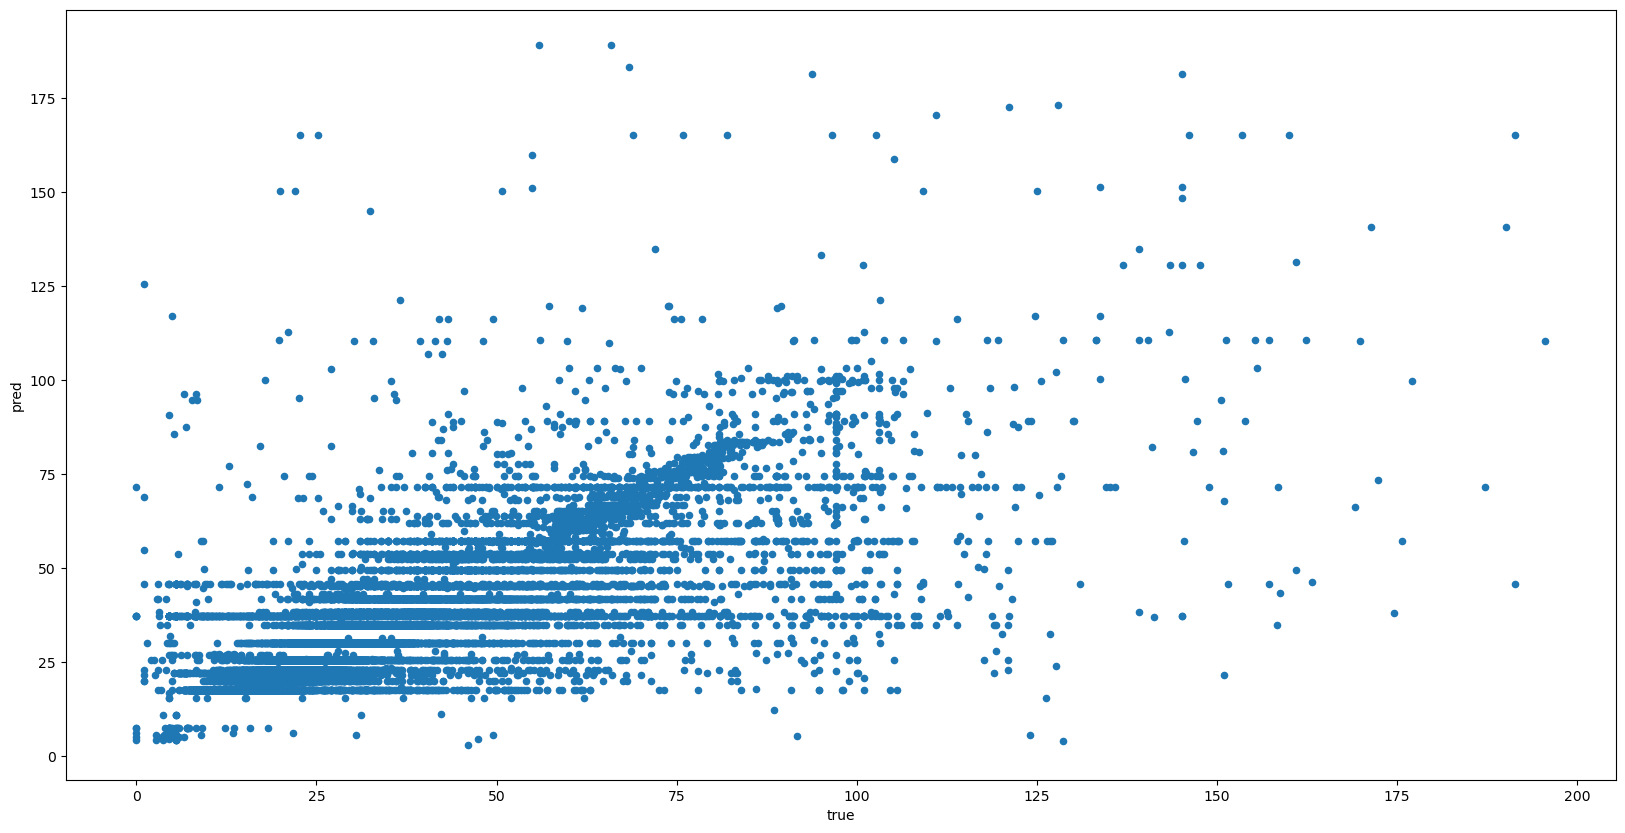

In [55]:
data={'true':y_test_b,'pred':y_pred_b}
results=pd.DataFrame(data)

results.plot(figsize=(20,10),kind='scatter',x='true',y='pred')

## 5.4. Fix problems <a id='Fix problems'></a>

mean_absolute_error 11.438307016333571
mean_squared_error 283.34968048711573
root_mean_absolute_error 3.3820566252405606
r2 0.23900480612811836


<Axes: xlabel='true', ylabel='pred'>

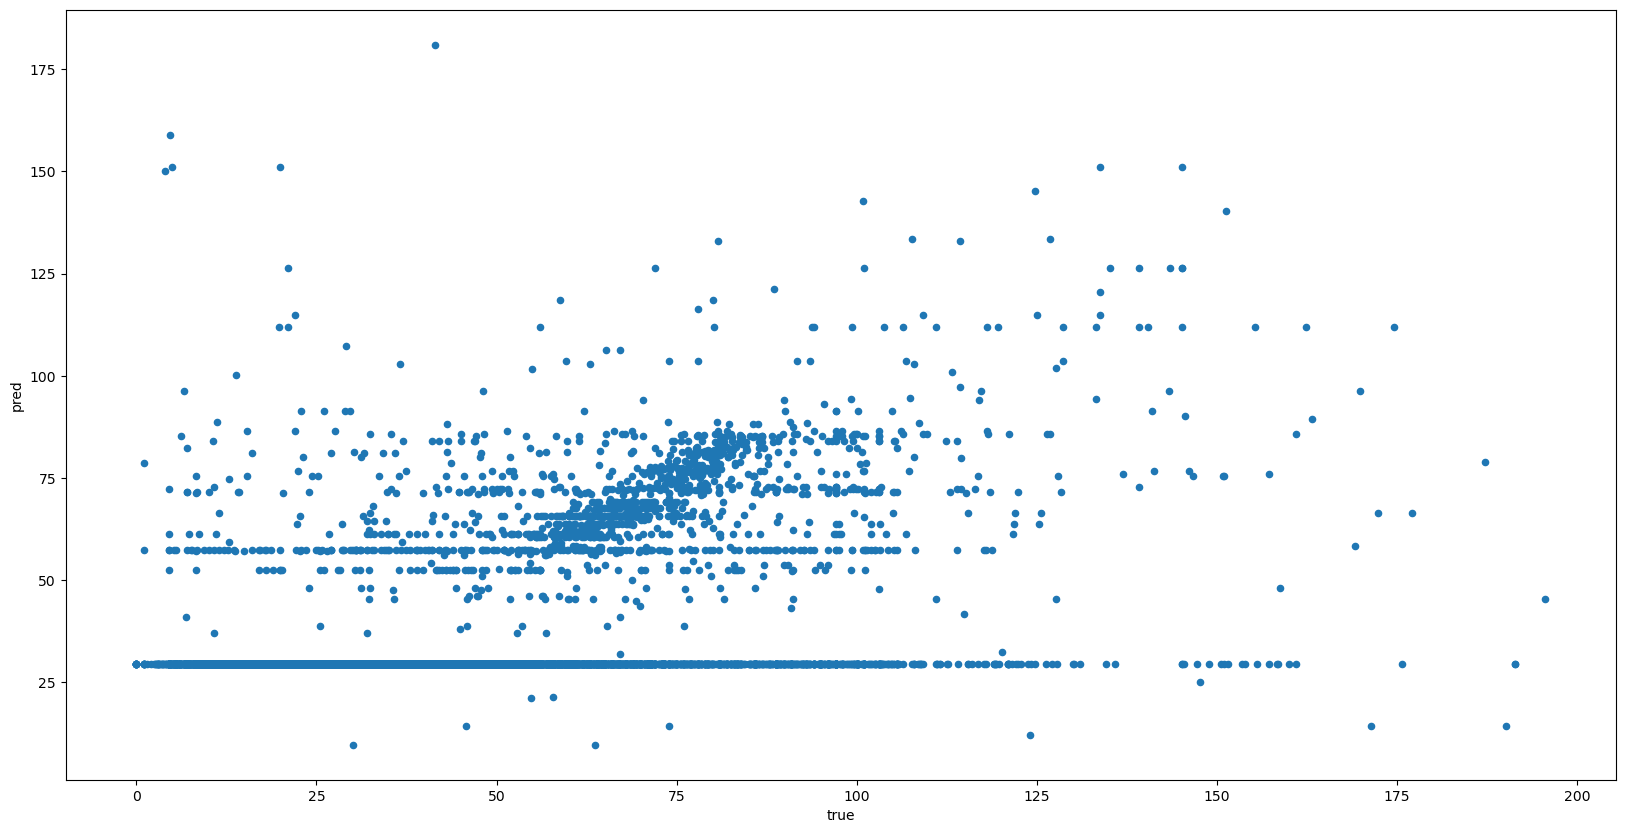

In [57]:
# trip_distance is correlated to the total_amount, so the model is biased, let's remove trip_distance from the features
categorical_features_benchmark=['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark=categorical_features_benchmark
target_feature_benchmark='total_amount'

# train and test split
x_bench=data_for_benchmark_model[input_features_benchmark]
y_bench=data_for_benchmark_model[target_feature_benchmark]

x_bench=pd.get_dummies(x_bench)

x_train_b, x_test_b, y_train_b, y_test_b=train_test_split(x_bench, y_bench, test_size=0.33, random_state=42)

#fit a model
tree=DecisionTreeRegressor(max_depth=10)
tree.fit(x_train_b,y_train_b)

# evaluate model
model_at_hand=tree

y_pred_b=model_at_hand.predict(x_test_b)

print('mean_absolute_error',mean_absolute_error(y_test_b,y_pred_b))
print('mean_squared_error',mean_squared_error(y_test_b,y_pred_b))
print('root_mean_absolute_error',sqrt(mean_absolute_error(y_test_b,y_pred_b)))
print('r2',r2_score(y_test_b,y_pred_b))

data={'true':y_test_b,'pred':y_pred_b}
results=pd.DataFrame(data)

results.plot(figsize=(20,10),kind='scatter',x='true',y='pred')


# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

In [59]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2024-01-01,1,1,5,0.000000,109.200000,1
1,1,2024-01-01,1,1,6,0.020000,76.000000,1
2,1,2024-01-01,1,1,13,0.000000,108.983333,1
3,1,2024-01-01,1,1,14,0.001667,85.680000,1
4,1,2024-01-01,1,1,15,0.000000,145.620000,1


In [60]:
data_with_new_features=taxi_grouped_by_region.copy()

### Date-related features

In [62]:
# maybe Weekend are likely to have more demand on taxi
data_with_new_features['transaction_week_day']=data_with_new_features['transaction_date'].dt.weekday
data_with_new_features['weekend']=data_with_new_features['transaction_week_day'].apply(lambda x: True if x==5 or x==6 else False)
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False
1,1,2024-01-01,1,1,6,0.020000,76.000000,1,0,False
2,1,2024-01-01,1,1,13,0.000000,108.983333,1,0,False
3,1,2024-01-01,1,1,14,0.001667,85.680000,1,0,False
4,1,2024-01-01,1,1,15,0.000000,145.620000,1,0,False


In [63]:
# maybe holiday may have or may not have more demand on taxi
from pandas.tseries.holiday import USFederalHolidayCalendar

cal=USFederalHolidayCalendar()
holidays=cal.holidays(start='2023', end='2025').date
data_with_new_features['is_holiday']=data_with_new_features['transaction_date'].isin(holidays)
data_with_new_features.head()

/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/715366350.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data_with_new_features['is_holiday']=data_with_new_features['transaction_date'].isin(holidays)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True
1,1,2024-01-01,1,1,6,0.020000,76.000000,1,0,False,True
2,1,2024-01-01,1,1,13,0.000000,108.983333,1,0,False,True
3,1,2024-01-01,1,1,14,0.001667,85.680000,1,0,False,True
4,1,2024-01-01,1,1,15,0.000000,145.620000,1,0,False,True


In [64]:
zone_lookup=pd.read_csv('data/taxi_zone_lookup.csv')
zone_lookup=zone_lookup[['LocationID','Borough']]
zone_lookup['LocationID']=zone_lookup['LocationID'].astype(str)

print(zone_lookup.dtypes)
zone_lookup.head()

LocationID    object
Borough       object
dtype: object


,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [65]:
data_with_new_features=data_with_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')

In [66]:
data_with_new_features.drop('LocationID',axis=1,inplace=True)
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True,EWR
1,1,2024-01-01,1,1,6,0.020000,76.000000,1,0,False,True,EWR
2,1,2024-01-01,1,1,13,0.000000,108.983333,1,0,False,True,EWR
3,1,2024-01-01,1,1,14,0.001667,85.680000,1,0,False,True,EWR
4,1,2024-01-01,1,1,15,0.000000,145.620000,1,0,False,True,EWR


In [67]:
data_with_new_features['Borough'].value_counts()

Borough
Manhattan        42075
Queens           14978
Brooklyn         13558
Bronx             5283
Unknown            722
EWR                181
Staten Island       68
Name: count, dtype: int64

### Weather related features

In [192]:
nyc_weather=pd.read_csv('data/nyc_weather.csv')
print(nyc_weather.dtypes)
nyc_weather.head()

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                 object
amount of precipitation     object
dtype: object


,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2024 22:00,6.1,65,6,100%.,0.3
1,31.12.2024 19:00,6.7,71,5,70 – 80%.,NaN
2,31.12.2024 16:00,7.2,66,5,50%.,NaN
3,31.12.2024 13:00,6.1,76,3,100%.,Trace of precipitation
4,31.12.2024 10:00,4.4,83,2,100%.,Trace of precipitation


In [193]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   4
amount of precipitation    2240
dtype: int64

we can see that 'amount of precipitation', got missing values. and for "cloud cover" there type issue

In [195]:
#let's start with 'cloud cover'
nyc_weather['cloud cover'].value_counts()

cloud cover
70 – 80%.                                                     973
100%.                                                         896
20–30%.                                                       479
50%.                                                          413
no clouds                                                     168
Sky obscured by fog and/or other meteorological phenomena.      3
Name: count, dtype: int64

In [196]:
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('70 – 80%.',0.7)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('100%.',1)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('20–30%.',0.3)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('50%.',0.5)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('no clouds',0)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.',1)
nyc_weather['cloud cover']=nyc_weather['cloud cover'].astype(float)

nyc_weather['cloud cover'].interpolate(inplace=True)

/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/754638512.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nyc_weather['cloud cover']=nyc_weather['cloud cover'].replace('Sky obscured by fog and/or other meteorological phenomena.',1)
/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/754638512.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].meth

In [197]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2024 22:00,6.1,65,6,1.0,0.3
1,31.12.2024 19:00,6.7,71,5,0.7,NaN
2,31.12.2024 16:00,7.2,66,5,0.5,NaN
3,31.12.2024 13:00,6.1,76,3,1.0,Trace of precipitation
4,31.12.2024 10:00,4.4,83,2,1.0,Trace of precipitation


In [198]:
nyc_weather.isna().sum()

date and time                 0
temperature                   0
humidity                      0
wind speed                    0
cloud cover                   0
amount of precipitation    2240
dtype: int64

In [199]:
nyc_weather.dtypes
# now cloud cover is ready to use (it's numerical with no missing value), let's work on 'amount of precipitation'

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation     object
dtype: object

In [200]:
nyc_weather['amount of precipitation'].value_counts()

amount of precipitation
Trace of precipitation    266
0.3                        61
2.0                        49
1.0                        45
0.5                        42
0.8                        42
4.0                        33
5.0                        24
3.0                        23
6.0                        19
7.0                        13
8.0                        13
9.0                        11
10.0                       10
13.0                        7
12.0                        7
15.0                        6
11.0                        5
16.0                        3
22.0                        2
14.0                        2
29.0                        2
63.0                        1
21.0                        1
68.0                        1
17.0                        1
20.0                        1
30.0                        1
35.0                        1
34.0                        1
24.0                        1
18.0                        1
25.0            

In [201]:
nyc_weather['amount of precipitation']=nyc_weather['amount of precipitation'].replace('Trace of precipitation',0.1)
nyc_weather['amount of precipitation']=nyc_weather['amount of precipitation'].astype(float)

nyc_weather['amount of precipitation'].interpolate(inplace=True)

/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/3720726567.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nyc_weather['amount of precipitation'].interpolate(inplace=True)


In [202]:
print(nyc_weather.dtypes)
nyc_weather.head()

date and time               object
temperature                float64
humidity                     int64
wind speed                   int64
cloud cover                float64
amount of precipitation    float64
dtype: object


,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,31.12.2024 22:00,6.1,65,6,1.0,0.300000
1,31.12.2024 19:00,6.7,71,5,0.7,0.233333
2,31.12.2024 16:00,7.2,66,5,0.5,0.166667
3,31.12.2024 13:00,6.1,76,3,1.0,0.100000
4,31.12.2024 10:00,4.4,83,2,1.0,0.100000


In [203]:
#now that 'amount of precipitation' is ready, let's finaly look into the date value
nyc_weather['date and time']=pd.to_datetime(nyc_weather['date and time'])

/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/4186164221.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  nyc_weather['date and time']=pd.to_datetime(nyc_weather['date and time'])


In [204]:
nyc_weather['hour']=nyc_weather['date and time'].dt.hour
nyc_weather['month']=nyc_weather['date and time'].dt.month
nyc_weather['day']=nyc_weather['date and time'].dt.day

In [205]:
nyc_weather.head()

,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,2024-12-31 22:00:00,6.1,65,6,1.0,0.300000,22,12,31
1,2024-12-31 19:00:00,6.7,71,5,0.7,0.233333,19,12,31
2,2024-12-31 16:00:00,7.2,66,5,0.5,0.166667,16,12,31
3,2024-12-31 13:00:00,6.1,76,3,1.0,0.100000,13,12,31
4,2024-12-31 10:00:00,4.4,83,2,1.0,0.100000,10,12,31


In [206]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True,EWR
1,1,2024-01-01,1,1,6,0.020000,76.000000,1,0,False,True,EWR
2,1,2024-01-01,1,1,13,0.000000,108.983333,1,0,False,True,EWR
3,1,2024-01-01,1,1,14,0.001667,85.680000,1,0,False,True,EWR
4,1,2024-01-01,1,1,15,0.000000,145.620000,1,0,False,True,EWR


In [207]:
nyc_taxi_with_weather=data_with_new_features.merge(nyc_weather,left_on=['transaction_month','transaction_day','transaction_hour'], right_on=['month','day','hour'], how='left')
print(nyc_taxi_with_weather.shape)
nyc_taxi_with_weather.head()

(77432, 21)


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,...,Borough,date and time,temperature,humidity,wind speed,cloud cover,amount of precipitation,hour,month,day
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-01-01,1,1,6,0.020000,76.000000,1,0,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2024-01-01,1,1,13,0.000000,108.983333,1,0,False,...,EWR,2024-01-01 13:00:00,12.2,51.0,9.0,0.7,0.446667,13.0,1.0,1.0
3,1,2024-01-01,1,1,14,0.001667,85.680000,1,0,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2024-01-01,1,1,15,0.000000,145.620000,1,0,False,...,EWR,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
nyc_taxi_with_weather=nyc_taxi_with_weather.drop(['date and time','month','day','hour'],axis=1)

In [209]:
nyc_taxi_with_weather.isna().sum()

PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
Borough                      567
temperature                49742
humidity                   49742
wind speed                 49742
cloud cover                49742
amount of precipitation    49742
dtype: int64

In [210]:
nyc_taxi_with_weather[nyc_taxi_with_weather['Borough'].isna()]

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
54878,265,2024-01-01,1,1,0,7.422857,86.340000,1,0,False,True,NaN,NaN,NaN,NaN,NaN,NaN
54879,265,2024-01-01,1,1,1,2.283333,85.433333,1,0,False,True,NaN,8.3,97.0,0.0,1.0,29.000000
54880,265,2024-01-01,1,1,2,0.689231,68.409231,1,0,False,True,NaN,NaN,NaN,NaN,NaN,NaN
54881,265,2024-01-01,1,1,3,0.612308,95.803077,1,0,False,True,NaN,NaN,NaN,NaN,NaN,NaN
54882,265,2024-01-01,1,1,4,3.972222,58.865556,1,0,False,True,NaN,12.2,93.0,7.0,1.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55440,265,2024-01-31,1,31,15,9.450000,97.160000,1,2,False,False,NaN,NaN,NaN,NaN,NaN,NaN
55441,265,2024-01-31,1,31,17,3.733333,114.500000,1,2,False,False,NaN,NaN,NaN,NaN,NaN,NaN
55442,265,2024-01-31,1,31,19,5.760000,79.970000,1,2,False,False,NaN,-9.4,33.0,6.0,0.3,0.157143
55443,265,2024-01-31,1,31,20,0.025000,124.000000,1,2,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# Drop rows where 'Borough' is NaN because it's outside of NYC
nyc_taxi_with_weather = nyc_taxi_with_weather.dropna(subset=['Borough'])

print(nyc_taxi_with_weather.isna().sum())


PULocationID                   0
transaction_date               0
transaction_month              0
transaction_day                0
transaction_hour               0
trip_distance                  0
total_amount                   0
count_of_transactions          0
transaction_week_day           0
weekend                        0
is_holiday                     0
Borough                        0
temperature                49380
humidity                   49380
wind speed                 49380
cloud cover                49380
amount of precipitation    49380
dtype: int64


In [226]:
# sort and interpolate to fill the missing values
nyc_taxi_with_weather=nyc_taxi_with_weather.sort_values(['transaction_date','transaction_hour']).reset_index(drop=True)

In [228]:
nyc_taxi_with_weather.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,10,2024-01-01,1,1,0,4.810000,40.748333,1,0,False,True,Queens,NaN,NaN,NaN,NaN,NaN
1,100,2024-01-01,1,1,0,1.611111,24.853333,1,0,False,True,Manhattan,NaN,NaN,NaN,NaN,NaN
2,101,2024-01-01,1,1,0,11.320000,51.580000,1,0,False,True,Queens,NaN,NaN,NaN,NaN,NaN
3,102,2024-01-01,1,1,0,5.150000,23.270000,1,0,False,True,Queens,NaN,NaN,NaN,NaN,NaN
4,107,2024-01-01,1,1,0,1.988056,22.900556,1,0,False,True,Manhattan,NaN,NaN,NaN,NaN,NaN


In [230]:
nyc_taxi_with_weather=nyc_taxi_with_weather.interpolate()
nyc_taxi_with_weather=nyc_taxi_with_weather.fillna(method='bfill')
print(nyc_taxi_with_weather.isna().sum())
nyc_taxi_with_weather.head()

PULocationID               0
transaction_date           0
transaction_month          0
transaction_day            0
transaction_hour           0
trip_distance              0
total_amount               0
count_of_transactions      0
transaction_week_day       0
weekend                    0
is_holiday                 0
Borough                    0
temperature                0
humidity                   0
wind speed                 0
cloud cover                0
amount of precipitation    0
dtype: int64


/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/4070618435.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  nyc_taxi_with_weather=nyc_taxi_with_weather.interpolate()
/var/folders/1s/2d_x385j00b_qkrg61jq_7cc0000gn/T/ipykernel_20073/4070618435.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nyc_taxi_with_weather=nyc_taxi_with_weather.fillna(method='bfill')


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,temperature,humidity,wind speed,cloud cover,amount of precipitation
0,10,2024-01-01,1,1,0,4.810000,40.748333,1,0,False,True,Queens,8.3,97.0,0.0,1.0,29.0
1,100,2024-01-01,1,1,0,1.611111,24.853333,1,0,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0
2,101,2024-01-01,1,1,0,11.320000,51.580000,1,0,False,True,Queens,8.3,97.0,0.0,1.0,29.0
3,102,2024-01-01,1,1,0,5.150000,23.270000,1,0,False,True,Queens,8.3,97.0,0.0,1.0,29.0
4,107,2024-01-01,1,1,0,1.988056,22.900556,1,0,False,True,Manhattan,8.3,97.0,0.0,1.0,29.0


# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)